# **<h3 align="center"> Big Data Analytics - Project </h3>**
# **<h3 align="center">Stock Sentiment</h3>**
### **<h3 align="center">Prediction market behavior from US News Notebook</h3>**

**Group _ members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>

# Table of Contents
1. Introduction  
2. Necessary Extensions and Imports
3. News Data Pipeline  
   - 3.1 Ingest and Inspect News Data  
   - 3.2 Group Articles by Day and Topic  
   - 3.3 TF-IDF Feature Extraction  
   - 3.4 Sentiment Analysis Using BERT  
4. News Data Pipeline   
5. Exploratory Data Analysis (EDA)  
6. Machine Learning  
7. Predictive Modeling  
8. Insights and Conclusions






# 1. Introduction

In this notebook, we analyze news articles from the New York Times over a 1-year period (April 2024 to April 2025). Our goal is to extract topic-specific features from headlines using TF-IDF and correlate them with market behavior (specifically, the SPY stock index). The main steps include:

- Pulling and storing NYT and SPY stock data
- Preprocessing and grouping headlines by topic and day
- Computing daily TF-IDF vectors per topic
- Generating pivot tables of article counts and TF-IDF values
- Joining with stock market data for correlation analysis


# 2. Necessary Extensions and Imports

In this section, we install any required extensions and import the necessary libraries to support the operations throughout the notebook, including data ingestion, processing, and analysis.



In [0]:
# Upgrade typing_extensions to a version MLflow expects
%pip install --upgrade typing_extensions

%pip install alpaca_trade_api

# Install (or reinstall) MLflow
%pip install --upgrade mlflow

#Since we decided to use XGBoost as an ml algorithm we need to also install
%pip install xgboost

# Restart the Python process so the new packages take effect
dbutils.library.restartPython()


import requests, json
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofmonth, hour

from pyspark.sql import functions as F
from pyspark.sql.functions import to_timestamp, col, concat_ws, collect_list, count, window
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import PipelineModel

import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST
from pyspark.sql.functions import to_timestamp, year, month, dayofmonth

import os
os.environ["PYSPARK_PIN_THREAD"] = "false"


Python interpreter will be restarted.
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-fa61d53b-5048-47f5-8e96-7319a9b6ec9a
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Not uninstalling requests at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-fa61d53b-5048-47f5-8e96-7319a9b6ec9a
    Can't uninstall 'requests'. No files were found to uninstall.
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.0.1
    Not uninstalling markupsaf

**!Only Run when all data sets are created!**

Reestablishes Hive lookups for the Delta tables

In [0]:
spark.sql(f"""
  CREATE TABLE IF NOT EXISTS nyt_archive
  USING DELTA
  LOCATION "/mnt/nyt/archive_yearly_delta"
""")

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS news_tfidfs
  USING DELTA
  LOCATION "/mnt/nyt/news_tfidfs"
""")

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS stock_daily
  USING DELTA
  LOCATION "/mnt/nyt/stock_daily"
""")

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS stock_news_merged
  USING DELTA
  LOCATION "/mnt/nyt/stock_news_merged"
""")

Out[1]: DataFrame[]

In [0]:
%sql
DESCRIBE DETAIL nyt_archive

format id name description location createdAt lastModified partitionColumns numFiles sizeInBytes properties minReaderVersion minWriterVersion tableFeatures statistics delta 5e026a8a-0609-4173-89be-d284bc817778 spark_catalog.default.nyt_archive null dbfs:/mnt/nyt/archive_yearly_delta 2025-06-02T09:23:57.471+0000 2025-06-02T14:36:52.000+0000 List(yr, mo, dy, hr) 5364 9947554 Map() 1 2 List(appendOnly, invariants) Map()

# 3. News Data Pipeline  

In the following cells, we will load and inspect the NYT headlines dataset
We start by reading the cleaned and partitioned news data from the Delta table `nyt_archive`.

It is also important to understand our use of first Delta and then Hive.
| Step                  | Component        | Purpose                                                                                                |
| --------------------- | ---------------- | ------------------------------------------------------------------------------------------------------ |
| **1. Save data**      | **Delta format** | Efficient, ACID-compliant storage of large datasets. We write the table with this format.                  |
| **2. Register table** | **Hive table**   | Adds a logical name (`nyt_archive`) to the Delta data so we can query it with SQL or `spark.table()`. |

We use Delta to store the data efficiently and Hive to make it easy to access and query. It’s the combination that gives us both performance and usability.

## 3.1. Ingest and Inspect News Data




In [0]:
# 4) Register as a Hive table for easy querying
spark.sql(f"""
  CREATE TABLE IF NOT EXISTS nyt_archive
  USING DELTA
  LOCATION "/mnt/nyt/archive_yearly_delta"
""")


Out[5]: DataFrame[]

In [0]:
%sql
DESCRIBE DETAIL nyt_archive;

format id name description location createdAt lastModified partitionColumns numFiles sizeInBytes properties minReaderVersion minWriterVersion tableFeatures statistics delta 5e026a8a-0609-4173-89be-d284bc817778 spark_catalog.default.nyt_archive null dbfs:/mnt/nyt/archive_yearly_delta 2025-06-02T09:23:57.471+0000 2025-06-02T14:36:52.000+0000 List(yr, mo, dy, hr) 5364 9947554 Map() 1 2 List(appendOnly, invariants) Map()

In [0]:
# Deletes everything under that path, recursively
dbutils.fs.rm("/mnt/nyt/archive_yearly_delta", recurse=True)


Out[1]: True

In [0]:
# =============================
# NYTimes Archive Ingestion
# =============================

API_KEY     = "9cLqd9jAufochxZTdf3XW0MVh4mvzGIO"
BASE_URL    = "https://api.nytimes.com/svc/archive/v1"
DELTA_PATH  = "/mnt/nyt/archive_yearly_delta"   # final Delta store

# Importing required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofmonth, hour
import requests
import json


# Let's Initialize Spark
spark = SparkSession.builder.getOrCreate()

# We define that the date range will: April 2024 → April 2025
start_year, start_month = 2025, 1
end_year,   end_month   = 2025, 4

months = []
y, m = start_year, start_month
while (y < end_year) or (y == end_year and m <= end_month):
    months.append((y, m))
    m += 1
    if m == 13:
        m = 1
        y += 1

# Loop and append each month’s headlines to Delta 
for y, m in months:
    url    = f"{BASE_URL}/{y}/{m}.json"
    params = {"api-key": API_KEY}

    resp = requests.get(url, params=params)
    resp.raise_for_status()
    docs = resp.json().get("response", {}).get("docs", [])
    if not docs:
        continue

    # parallelize & read JSON
    rdd = spark.sparkContext.parallelize([json.dumps(d) for d in docs])
    df  = spark.read.json(rdd)

    # Select only the relevant fields for analysis:
    # - 'headline': used for text analysis (TF-IDF, topic modeling)
    # - 'pub_date': used to align news with stock market timestamps
    # - 'section_name' (renamed as 'topic'): serves as a proxy for the topic/category of each article, we will also use this later to check if there is any correlation between topics and the target
    df_sel = df.select(
        col("headline.main").alias("headline"),
        col("pub_date").alias("pub_date"),
        col("section_name").alias("topic")
    )

    # add partition columns
    df_part = df_sel.withColumn("yr", year("pub_date")) \
                    .withColumn("mo", month("pub_date")) \
                    .withColumn("dy", dayofmonth("pub_date")) \
                    .withColumn("hr", hour("pub_date"))

    # write into Delta (append mode), partitioned
    df_part.write \
           .format("delta") \
           .mode("append") \
           .partitionBy("yr","mo","dy","hr") \
           .save(DELTA_PATH)

# 4) Register as a Hive table for easy querying
spark.sql(f"""
  CREATE TABLE IF NOT EXISTS nyt_archive
  USING DELTA
  LOCATION '{DELTA_PATH}'
""")

Out[5]: DataFrame[]

Now let's check the dataset.

In [0]:
# Verify by reading & displaying a sample
news_df = spark.table("nyt_archive")
display(news_df)

headline pub_date topic yr mo dy hr Why Some Men Find Orgasms Elusive 2025-03-07T10:00:03+0000 Well 2025 3 7 10 How Do You Like Your History? With Imaginative Leaps or Grounded in Fact? 2025-03-07T10:00:10+0000 Books 2025 3 7 10 For an Indian Textiles Designer, It Takes Many Villages 2025-03-07T10:00:17+0000 Arts 2025 3 7 10 Bright Lights, Bot City: Having A.I. Plan a Dream Trip to New York 2025-03-07T10:00:25+0000 Travel 2025 3 7 10 After an Abortion and a Separation, a 30-Something Flails Toward Adulthood 2025-03-07T10:00:25+0000 Books 2025 3 7 10 The Art World’s Next Big Thing: Tiny Paintings 2025-03-07T10:00:34+0000 T Magazine 2025 3 7 10 One Fire, Two Burned Homes and Wildly Different Insurance Outcomes 2025-03-07T10:00:36+0000 Real Estate 2025 3 7 10 A Peeling 17th-Century Palazzo and the Man Who Was ‘Crazy Enough’ to Buy It 2025-03-07T10:00:47+0000 T Magazine 2025 3 7 10 A Hamas Leader’s Release From Prison Reopens Old Wounds in Israel 2025-03-07T10:00:55+0000 World 2025 3 7 10 5 Children’s Movies to Stream Now 2025-03-07T10:01:00+0000 Movies 2025 3 7 10 A Garden Writer’s Novel Bears Fruit 2025-03-07T10:01:00+0000 Books 2025 3 7 10 ‘Housewife of the Year’: Contestants Look Back in Dismay 2025-03-07T10:01:41+0000 Movies 2025 3 7 10 Just Before It Was a Cult Film, ‘Rocky Horror Show’ Was a Broadway Flop 2025-03-07T10:01:48+0000 Theater 2025 3 7 10 As King Urges People Not to Kill Sheep for ‘Big Eid,’ Many Moroccans Feel Relief 2025-03-07T10:01:54+0000 World 2025 3 7 10 Step Into the Real-Life Lumon Industries, the Breakout Star of ‘Severance’ 2025-03-07T10:01:55+0000 Real Estate 2025 3 7 10 A Panorama of Design 2025-03-07T10:02:02+0000 Style 2025 3 7 10 No Diamonds Here, but These Gemstones Still Shine 2025-03-07T10:02:04+0000 Arts 2025 3 7 10 Meet Trump’s Anti-D.E.I. Crusader 2025-03-07T10:02:10+0000 Opinion 2025 3 7 10 Chrystia Freeland Steps Out of Trudeau’s Shadow as She Goes for His Job 2025-03-07T10:02:11+0000 World 2025 3 7 10 It’s Spring Forward Time for Some Famous New York Clocks 2025-03-07T10:02:14+0000 New York 2025 3 7 10 Back to Minneapolis and a House With a Pedigree 2025-03-07T10:02:25+0000 Real Estate 2025 3 7 10 As Layoffs Continue, Federal Workers Face Sluggish Job Market 2025-03-07T10:02:32+0000 Business Day 2025 3 7 10 Elon Musk Should Take a Hard Look at One Agency Truly Wasting Taxpayer Dollars 2025-03-07T10:02:37+0000 Opinion 2025 3 7 10 $850,000 Homes in Montpellier, France 2025-03-07T10:02:40+0000 Real Estate 2025 3 7 10 Will Canadians Warm Up to the Steely Banker Eyeing Trudeau’s Job? 2025-03-07T10:02:48+0000 World 2025 3 7 10 11 New Movies Our Critics Are Talking About This Week 2025-03-07T10:02:53+0000 Movies 2025 3 7 10 Jonas Mekas, Master of Avant-Garde Film, Shows His Tender Side 2025-03-07T10:03:01+0000 Movies 2025 3 7 10 The One Question That Really Matters: If Trump Defies the Courts, Then What? 2025-03-07T10:03:04+0000 Opinion 2025 3 7 10 George Lowe, 67, Dies; Five Clips Capture His Kvetchy Space Ghost Alter Ego 2025-03-07T10:03:13+0000 Arts 2025 3 7 10 How Trump’s ‘51st State’ Canada Talk Came to Be Seen as Deadly Serious 2025-03-07T10:03:21+0000 World 2025 3 7 10 I’m a Rust Belt Democrat From a Swing District. Anti-Tariff Absolutism Is a Mistake. 2025-03-07T10:03:43+0000 Opinion 2025 3 7 10 South Carolina Executes Inmate by Firing Squad 2025-03-07T10:03:48+0000 U.S. 2025 3 7 10 Republican Voters Support Medicaid but Want Work Requirements, Poll Finds 2025-03-07T10:03:54+0000 Health 2025 3 7 10 Anselm Kiefer Wonders if We’ll Ever Learn 2025-03-07T10:04:03+0000 Arts 2025 3 7 10 Lizzo Makes a Rock-Star Turn 2025-03-07T10:04:09+0000 Podcasts 2025 3 7 10 Bourdain and Batali’s Assistant Spills Some Secrets 2025-03-07T10:04:15+0000 Food 2025 3 7 10 Trump’s Policies Have Shaken a Once-Solid Economic Outlook 2025-03-07T10:04:22+0000 Business Day 2025 3 7 10 The Anti-D.E.I. Crusader Who Wants to Dismantle the Department of Education 2025-03-07T10:04:27+0000 Opinion 2025 3 7 10 ‘Mickey 17’ and 

## 3.2. Group Articles by Day and Topic 
We tokenize, remove stopwords, apply hashing TF and compute IDF values to get sparse vector representations of topic-specific documents.


In [0]:
from pyspark.sql.functions import (
    to_timestamp,
    year,
    month,
    dayofmonth,
    window,        # <— import window
    col,           # <— import col
    collect_list,  # <— import collect_list
    concat_ws,
    count
)

articles = (
    spark
      .table("nyt_archive")
      .withColumn("timestamp", to_timestamp(col("pub_date")))
      .select("timestamp", "headline", "topic")
)

grouped = (
    articles
      .groupBy(
         window("timestamp", "24 hours").alias("time_window"),
         col("topic")
      )
      .agg(
         concat_ws(" ", collect_list("headline")).alias("document"),
         count("*").alias("article_count")
      )
      .select(
         col("time_window").getField("start").alias("window_start"),
         col("time_window").getField("end").alias("window_end"),
         "topic",
         "document",
         "article_count"
      )
      .orderBy("window_start", "topic")
)

grouped.show()


## 3.2. Compute TF-IDF Features
We tokenize, remove stopwords, apply hashing TF and compute IDF values to get sparse vector representations of topic-specific documents.

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import size, when, col
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF

# ------------------------------
# 1) Define your TF–IDF pipeline
# ------------------------------
tokenizer = RegexTokenizer(inputCol="document", outputCol="words", pattern="\\W+")
stopper   = StopWordsRemover(inputCol="words", outputCol="filtered")
hashTF    = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1<<14)
idf       = IDF(inputCol="rawFeatures", outputCol="tfidfFeatures")

tfidf_pipeline = Pipeline(stages=[tokenizer, stopper, hashTF, idf])

# --------------------------------------------
# 2) Fit on your grouped DataFrame and transform
# --------------------------------------------
tfidf_model = tfidf_pipeline.fit(grouped)
tfidf_df    = tfidf_model.transform(grouped)

# -------------------------------------------------------------------
# 3) Now force `tfidfFeatures = NULL` whenever `filtered` is empty (size=0)
# -------------------------------------------------------------------
tfidf_df = tfidf_df.withColumn(
    "tfidfFeatures",
    when(size(col("filtered")) == 0, None)    # replace with null if no tokens
    .otherwise(col("tfidfFeatures"))
)


## 3.3. Pivot Data for Analysis
We create wide-format tables for both article counts and TF-IDF vectors, which will later be used for correlation analysis.

In [0]:
spark.sql(f"""
  CREATE TABLE IF NOT EXISTS news_tfidfs
  USING DELTA
  LOCATION "/mnt/nyt/news_tfidfs"
""")

Out[13]: DataFrame[]

In [0]:
%sql
DESCRIBE DETAIL news_tfidfs

format id name description location createdAt lastModified partitionColumns numFiles sizeInBytes properties minReaderVersion minWriterVersion tableFeatures statistics delta 98fa91ca-f363-4fc3-bf2a-d0c81115eecc spark_catalog.default.news_tfidfs null dbfs:/mnt/nyt/news_tfidfs 2025-06-02T09:48:19.780+0000 2025-06-02T09:52:55.000+0000 List() 1 556257 Map() 1 2 List(appendOnly, invariants) Map()

In [0]:
# Deletes everything under that path, recursively
dbutils.fs.rm("/mnt/nyt/news_tfidfs", recurse=True)

Out[10]: True

In [0]:
import re  # For the sanitize() function

from pyspark.sql.functions import (
    col,
    first,
    to_timestamp,
    concat_ws,
    collect_list,
    count,
    window
)
# Helper to make column‐safe names
def sanitize(name: str) -> str:
    # replace non-alphanumeric with underscore, collapse multiple, strip edges
    s = re.sub(r'\W+', '_', name)
    return re.sub(r'_+', '_', s).strip('_')

# Pivot article counts
counts_pivot = (
    tfidf_df
      .groupBy("window_start", "window_end")
      .pivot("topic")
      .agg(first("article_count"))            
)

# Pivot TF-IDF vectors
tfidf_pivot = (
    tfidf_df
      .groupBy("window_start", "window_end")
      .pivot("topic")
      .agg(first("tfidfFeatures"))
)

# Rename columns to more understandable names and add appropriate prefixes
counts_safe = counts_pivot
for col_name in counts_pivot.columns:
    if col_name not in ("window_start", "window_end"):
        safe = sanitize(col_name)
        counts_safe = counts_safe.withColumnRenamed(col_name, f"count_{safe}")

tfidf_safe = tfidf_pivot
for col_name in tfidf_pivot.columns:
    if col_name not in ("window_start", "window_end"):
        safe = sanitize(col_name)
        tfidf_safe = tfidf_safe.withColumnRenamed(col_name, f"tfidf_{safe}")

# Join the two
final_df = counts_safe.join(
    tfidf_safe,
    on=["window_start", "window_end"],
    how="inner"
)

# Persist and register
OUT_PATH = "/mnt/nyt/news_tfidfs"

(
    final_df
      .write
      .format("delta")
      .mode("overwrite")
      .option("overwriteSchema", "true")
      .save(OUT_PATH)
)

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS news_tfidfs
  USING DELTA
  LOCATION '{OUT_PATH}'
""")

Out[11]: DataFrame[]

Let's open the dataset.


In [0]:
# Show schema & sampler
# Display a sample of the data
news_tfidfs = spark.table("news_tfidfs")
display(news_tfidfs.limit(10))


window_start window_end count_ count_Arts count_Automobiles count_Books count_Briefing count_Business_Day count_Climate count_Corrections count_Crosswords_Games count_Education count_Fashion_Style count_Food count_Headway count_Health count_International_Home count_Lens count_Magazine count_Movies count_New_York count_Obituaries count_Opinion count_Podcasts count_Polls count_Reader_Center count_Real_Estate count_Science count_Sports count_Style count_T_Brand count_T_Magazine count_Technology count_The_Learning_Network count_The_Upshot count_Theater count_Times_Insider count_Travel count_U_S count_Weather count_Well count_World count_Your_Money count_en_Español tfidf_ tfidf_Arts tfidf_Automobiles tfidf_Books tfidf_Briefing tfidf_Business_Day tfidf_Climate tfidf_Corrections tfidf_Crosswords_Games tfidf_Education tfidf_Fashion_Style tfidf_Food tfidf_Headway tfidf_Health tfidf_International_Home tfidf_Lens tfidf_Magazine tfidf_Movies tfidf_New_York tfidf_Obituaries tfidf_Opinion tfidf_Podcasts tfidf_Polls tfidf_Reader_Center tfidf_Real_Estate tfidf_Science tfidf_Sports tfidf_Style tfidf_T_Brand tfidf_T_Magazine tfidf_Technology tfidf_The_Learning_Network tfidf_The_Upshot tfidf_Theater tfidf_Times_Insider tfidf_Travel tfidf_U_S tfidf_Weather tfidf_Well tfidf_World tfidf_Your_Money tfidf_en_Español 2025-01-01T00:00:00.000+0000 2025-01-02T00:00:00.000+0000 0 5 0 2 3 1 0 2 4 0 0 1 0 1 0 0 3 2 5 0 7 0 0 0 1 5 0 2 0 0 0 0 0 1 0 2 21 0 2 14 0 0 Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(229, 255, 628, 931, 1542, 2491, 2950, 3115, 4111, 4426, 4779, 5014, 5471, 7249, 7752, 7903, 7913, 8323, 8324, 8934, 9445, 9536, 9575, 9629, 10040, 11287, 11449, 12112, 12459, 15245, 15544, 15939, 16355), values -> List(5.594035247054107, 6.605636158732587, 4.856436303923328, 5.158717175796261, 5.912488978172641, 6.046020370797164, 7.298783339292532, 4.002946473288203, 6.200171050624422, 5.689345426858432, 5.594035247054107, 4.557943315367331, 4.120729508944586, 3.9488792520179268, 5.283880318750267, 6.605636158732587, 2.9544356579598947, 3.0574565867217856, 2.378802413464407, 6.200171050624422, 6.382492607418377, 4.303051065738541, 6.200171050624422, 6.382492607418377, 4.381012607208253, 2.5582085162982375, 2.94207451260294, 4.495422958385997, 5.352873190237219, 5.352873190237219, 4.590733138190322, 6.605636158732587, 3.427582328384641)) Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(2870, 4612, 6717, 10069, 10445, 10998, 12912, 15337), values -> List(5.047491540686036, 8.200220443483701, 4.354344360126091, 5.352873190237219, 4.856436303923328, 7.298783339292532, 6.046020370797164, 4.624634689866003)) Map(vectorType -> sparse, length -> 16384, indices -> List(1832, 2733, 4878, 7913, 8036, 9985, 10106, 13209), values -> List(5.689345426858432, 3.6481250979987934, 5.42698116239094, 1.4772178289799474, 4.4365824583630635, 4.185268030082158, 4.328368873722831, 6.3758189502384415)) Map(vectorType -> sparse, length -> 16384, indices -> List(1434, 1752, 2038, 6118, 14154), values -> List(2.8561320828022154, 4.185268030082158, 7.298783339292532, 2.9293354868255106, 4.624634689866003)) Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(1018, 1509, 5065, 6313, 7249, 7994, 8301, 10731, 10965, 11287, 11694, 13994, 14500), values -> List(3.212807026740948, 2.668920540714069, 3.9488792520179268, 4.0406868012710495, 3.9488792520179268, 3.0361034622512166, 2.26508277226528, 2.6353442451804647, 4.590733138190322, 2.5582085162982375, 4.381012607208253, 4.100110221741851, 3.5730899120558792)) Map(vectorType -> sparse, length -> 16384, indices -> List(3857, 3951, 4903, 6222, 8324, 10731, 10890, 11928, 14051, 14225, 14275, 15548), values -> List(6.8933182311843675, 3.1797461644800595, 3.0574565867217856, 

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when
from pyspark.sql.types import StructType  # used only for type check
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

# 1) Read the Delta table
df = spark.table("news_tfidfs")

df = df.fillna(0)

# 2) Identify all 'tfidf_' columns of Vector type
vector_tfidf_cols = [
    field.name
    for field in df.schema.fields
    if field.name.startswith("tfidf_") and isinstance(field.dataType, VectorUDT)
]

# 3) Construct a zero‐vector of length 16384 (matching your HashingTF numFeatures)
zero_vec = Vectors.sparse(16384, [], [])

# 4) Define a UDF that returns zero_vec when the input is null, else returns the original vector
fill_zero_udf = udf(lambda v: zero_vec if v is None else v, VectorUDT())

# 5) Apply the UDF for each tfidf_ column to replace null with the zero vector
df_filled = df
for col_name in vector_tfidf_cols:
    df_filled = df_filled.withColumn(col_name, fill_zero_udf(col(col_name)))

# 6) Overwrite the Delta table with the null‐filled DataFrame (including schema overwrite)
(
    df_filled
      .write
      .format("delta")
      .mode("overwrite")
      .option("overwriteSchema", "true")
      .saveAsTable("news_tfidfs")
)

display(df_filled.limit(10))

window_start window_end count_ count_Arts count_Automobiles count_Books count_Briefing count_Business_Day count_Climate count_Corrections count_Crosswords_Games count_Education count_Fashion_Style count_Food count_Headway count_Health count_International_Home count_Lens count_Magazine count_Movies count_New_York count_Obituaries count_Opinion count_Podcasts count_Polls count_Reader_Center count_Real_Estate count_Science count_Sports count_Style count_T_Brand count_T_Magazine count_Technology count_The_Learning_Network count_The_Upshot count_Theater count_Times_Insider count_Travel count_U_S count_Weather count_Well count_World count_Your_Money count_en_Español tfidf_ tfidf_Arts tfidf_Automobiles tfidf_Books tfidf_Briefing tfidf_Business_Day tfidf_Climate tfidf_Corrections tfidf_Crosswords_Games tfidf_Education tfidf_Fashion_Style tfidf_Food tfidf_Headway tfidf_Health tfidf_International_Home tfidf_Lens tfidf_Magazine tfidf_Movies tfidf_New_York tfidf_Obituaries tfidf_Opinion tfidf_Podcasts tfidf_Polls tfidf_Reader_Center tfidf_Real_Estate tfidf_Science tfidf_Sports tfidf_Style tfidf_T_Brand tfidf_T_Magazine tfidf_Technology tfidf_The_Learning_Network tfidf_The_Upshot tfidf_Theater tfidf_Times_Insider tfidf_Travel tfidf_U_S tfidf_Weather tfidf_Well tfidf_World tfidf_Your_Money tfidf_en_Español 2025-01-01T00:00:00.000+0000 2025-01-02T00:00:00.000+0000 0 5 0 2 3 1 0 2 4 0 0 1 0 1 0 0 3 2 5 0 7 0 0 0 1 5 0 2 0 0 0 0 0 1 0 2 21 0 2 14 0 0 Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(229, 255, 628, 931, 1542, 2491, 2950, 3115, 4111, 4426, 4779, 5014, 5471, 7249, 7752, 7903, 7913, 8323, 8324, 8934, 9445, 9536, 9575, 9629, 10040, 11287, 11449, 12112, 12459, 15245, 15544, 15939, 16355), values -> List(5.594035247054107, 6.605636158732587, 4.856436303923328, 5.158717175796261, 5.912488978172641, 6.046020370797164, 7.298783339292532, 4.002946473288203, 6.200171050624422, 5.689345426858432, 5.594035247054107, 4.557943315367331, 4.120729508944586, 3.9488792520179268, 5.283880318750267, 6.605636158732587, 2.9544356579598947, 3.0574565867217856, 2.378802413464407, 6.200171050624422, 6.382492607418377, 4.303051065738541, 6.200171050624422, 6.382492607418377, 4.381012607208253, 2.5582085162982375, 2.94207451260294, 4.495422958385997, 5.352873190237219, 5.352873190237219, 4.590733138190322, 6.605636158732587, 3.427582328384641)) Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(2870, 4612, 6717, 10069, 10445, 10998, 12912, 15337), values -> List(5.047491540686036, 8.200220443483701, 4.354344360126091, 5.352873190237219, 4.856436303923328, 7.298783339292532, 6.046020370797164, 4.624634689866003)) Map(vectorType -> sparse, length -> 16384, indices -> List(1832, 2733, 4878, 7913, 8036, 9985, 10106, 13209), values -> List(5.689345426858432, 3.6481250979987934, 5.42698116239094, 1.4772178289799474, 4.4365824583630635, 4.185268030082158, 4.328368873722831, 6.3758189502384415)) Map(vectorType -> sparse, length -> 16384, indices -> List(1434, 1752, 2038, 6118, 14154), values -> List(2.8561320828022154, 4.185268030082158, 7.298783339292532, 2.9293354868255106, 4.624634689866003)) Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(1018, 1509, 5065, 6313, 7249, 7994, 8301, 10731, 10965, 11287, 11694, 13994, 14500), values -> List(3.212807026740948, 2.668920540714069, 3.9488792520179268, 4.0406868012710495, 3.9488792520179268, 3.0361034622512166, 2.26508277226528, 2.6353442451804647, 4.590733138190322, 2.5582085162982375, 4.381012607208253, 4.100110221741851, 3.5730899120558792)) Map(vectorType -> sparse, length -> 16384, indices -> List(3857, 3951, 4903, 6222, 8324, 10731, 10890, 11928, 14051, 14225, 14275, 15548), values -> List(6.8933182311843675, 3.1797461644800595, 3.0574565867217856, 

## 3.4. Sentiment Analysis Using Bert

Initially, we explored using an external API to retrieve sentiment labels for the news headlines. However, due to technical issues and limited control over the output, we decided to perform sentiment analysis independently using a pre-trained BERT model.

In this step, we apply BERT to assign sentiment scores (e.g., positive, neutral, negative) to each headline. Since we don't have a labeled target to validate the sentiment predictions against, we treat this as an exploratory, unsupervised analysis. The results should be interpreted with caution, but they allow us to experiment with integrating pre-trained models in Databricks and enhance our understanding of the emotional tone of the news data.


In [0]:
### CODE :)

# 4. Stock Data Pipeline 
We read the daily S&P data for the SPY index from the table `stock_daily`.


In [0]:
spark.sql(f"""
  CREATE TABLE IF NOT EXISTS stock_daily
  USING DELTA
  LOCATION "/mnt/nyt/stock_daily"
""")

Out[21]: DataFrame[]

In [0]:
%sql
DESCRIBE DETAIL stock_daily

format id name description location createdAt lastModified partitionColumns numFiles sizeInBytes properties minReaderVersion minWriterVersion tableFeatures statistics delta 619ec52e-dabc-47ab-a024-f396b6e10e7c spark_catalog.default.stock_daily null dbfs:/mnt/nyt/stock_daily 2025-05-26T12:00:32.651+0000 2025-06-01T18:06:33.000+0000 List(yr, mo, dy) 21 50963 Map() 1 2 List(appendOnly, invariants) Map()

In [0]:
# Deletes everything under that path, recursively
dbutils.fs.rm("/mnt/nyt/stock_daily", recurse=True)

Out[29]: True

In [0]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST
from pyspark.sql.functions import to_timestamp, year, month, dayofmonth

# ----------------------------
# Pull daily SPY bars
# ----------------------------
client = REST(
    "PKY96P1SK8M1NUKCCYSC",
    "Uf15nvt1cNm61OVbKudbnmwqhW155pr3PtdaB4gR",
    base_url="https://data.alpaca.markets",
    api_version="v2"
)

bars = client.get_bars(
    "SPY",
    tradeapi.TimeFrame(1, tradeapi.TimeFrameUnit.Day),
    start="2025-01-01",
    end="2025-04-30"
)
pdf = bars.df.reset_index().rename(columns={"index": "timestamp"})

# ✅ Keep timestamp column here
stock_df = (
    spark.createDataFrame(pdf)
          .withColumn("timestamp", to_timestamp("timestamp"))
)

# Add partition columns for efficient Delta storage
stock_part = (
    stock_df
      .withColumn("yr", year("timestamp"))
      .withColumn("mo", month("timestamp"))
      .withColumn("dy", dayofmonth("timestamp"))
)

# Save to Delta and register table
DELTA_STOCK_PATH = "/mnt/nyt/stock_daily"

stock_part.write \
    .format("delta") \
    .mode("overwrite") \
    .partitionBy("yr", "mo", "dy") \
    .save(DELTA_STOCK_PATH)

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS stock_daily
  USING DELTA
  LOCATION '{DELTA_STOCK_PATH}'
""")
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST
from pyspark.sql.functions import to_timestamp, year, month, dayofmonth

# ----------------------------
# Pull daily SPY bars
# ----------------------------
client = REST(
    "PKY96P1SK8M1NUKCCYSC",
    "Uf15nvt1cNm61OVbKudbnmwqhW155pr3PtdaB4gR",
    base_url="https://data.alpaca.markets",
    api_version="v2"
)

bars = client.get_bars(
    "SPY",
    tradeapi.TimeFrame(1, tradeapi.TimeFrameUnit.Day),
    start="2025-01-01",
    end="2025-04-30"
)
pdf = bars.df.reset_index().rename(columns={"index": "timestamp"})

# ✅ Keep timestamp column here
stock_df = (
    spark.createDataFrame(pdf)
          .withColumn("timestamp", to_timestamp("timestamp"))
)

# Add partition columns for efficient Delta storage
stock_part = (
    stock_df
      .withColumn("yr", year("timestamp"))
      .withColumn("mo", month("timestamp"))
      .withColumn("dy", dayofmonth("timestamp"))
)

# Save to Delta and register table
DELTA_STOCK_PATH = "/mnt/nyt/stock_daily"

stock_part.write \
    .format("delta") \
    .mode("overwrite") \
    .partitionBy("yr", "mo", "dy") \
    .save(DELTA_STOCK_PATH)

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS stock_daily
  USING DELTA
  LOCATION '{DELTA_STOCK_PATH}'
""")


Out[30]: DataFrame[]

Let's open the dataframe.

In [0]:

stock = spark.table("stock_daily")
display(stock.orderBy("timestamp").limit(10))

timestamp close high low trade_count open volume vwap yr mo dy 2025-01-02T05:00:00.000+0000 584.64 591.13 580.5 603951 589.39 50203975 585.069059 2025 1 2 2025-01-03T05:00:00.000+0000 591.95 592.6 586.43 427267 587.53 37888459 590.3249 2025 1 3 2025-01-06T05:00:00.000+0000 595.36 599.7 593.6 468834 596.27 47679442 596.616783 2025 1 6 2025-01-07T05:00:00.000+0000 588.63 597.75 586.78 489809 597.42 60393052 591.010705 2025 1 7 2025-01-08T05:00:00.000+0000 589.49 590.5799 585.195 432460 588.7 47304672 588.281771 2025 1 8 2025-01-10T05:00:00.000+0000 580.49 585.95 578.55 720924 585.88 73105046 581.355095 2025 1 10 2025-01-13T05:00:00.000+0000 581.39 581.75 575.35 505933 575.77 47910060 578.886779 2025 1 13 2025-01-14T05:00:00.000+0000 582.19 585.0 578.35 473554 584.36 48420580 581.845057 2025 1 14 2025-01-15T05:00:00.000+0000 592.78 593.94 589.195 488787 590.325 56900159 592.171696 2025 1 15 2025-01-16T05:00:00.000+0000 591.64 594.35 590.93 409217 594.175 44319662 592.628159 2025 1 16

# 5. Merging News and Stock Data

Before diving into Exploratory Data Analysis (EDA), we need to merge the datasets that we've built so far, specifically, the processed news data (with TF-IDF, article counts, and sentiment) and the stock market data (SPY daily prices). This combined dataset will allow us to explore how different news features relate to market behavior.

The merged dataset will include:
- Time-based alignment (by day)
- News features: article count per topic, TF-IDF vectors, sentiment scores
- Market target variable: daily SPY return or price movement

This step ensures all our features and targets are in one place for analysis and modeling.


In [0]:
from pyspark.sql.functions import to_date, col

# 1) Read directly from the Hive tables
stock_df = spark.table("stock_daily")
news_df  = spark.table("news_tfidfs")

# 2) Extract just the DATE part of each timestamp
stock_df = stock_df.withColumn("trade_date", to_date(col("timestamp")))
news_df  = news_df .withColumn("news_date",  to_date(col("window_start")))

# 3) Join on trade_date = news_date (inner join)
merged_df = (
    stock_df
      .join(news_df, stock_df.trade_date == news_df.news_date, "inner")
      .drop("trade_date", "news_date")
)

merged_df = merged_df.drop("yr", "mo", "dy", "window_start", "window_end")

display(merged_df.limit(10))


timestamp close high low trade_count open volume vwap count_ count_Arts count_Automobiles count_Books count_Briefing count_Business_Day count_Climate count_Corrections count_Crosswords_Games count_Education count_Fashion_Style count_Food count_Headway count_Health count_International_Home count_Lens count_Magazine count_Movies count_New_York count_Obituaries count_Opinion count_Podcasts count_Polls count_Reader_Center count_Real_Estate count_Science count_Sports count_Style count_T_Brand count_T_Magazine count_Technology count_The_Learning_Network count_The_Upshot count_Theater count_Times_Insider count_Travel count_U_S count_Weather count_Well count_World count_Your_Money count_en_Español tfidf_ tfidf_Arts tfidf_Automobiles tfidf_Books tfidf_Briefing tfidf_Business_Day tfidf_Climate tfidf_Corrections tfidf_Crosswords_Games tfidf_Education tfidf_Fashion_Style tfidf_Food tfidf_Headway tfidf_Health tfidf_International_Home tfidf_Lens tfidf_Magazine tfidf_Movies tfidf_New_York tfidf_Obituaries tfidf_Opinion tfidf_Podcasts tfidf_Polls tfidf_Reader_Center tfidf_Real_Estate tfidf_Science tfidf_Sports tfidf_Style tfidf_T_Brand tfidf_T_Magazine tfidf_Technology tfidf_The_Learning_Network tfidf_The_Upshot tfidf_Theater tfidf_Times_Insider tfidf_Travel tfidf_U_S tfidf_Weather tfidf_Well tfidf_World tfidf_Your_Money tfidf_en_Español 2025-01-02T05:00:00.000+0000 584.64 591.13 580.5 603951 589.39 50203975 585.069059 0 8 0 3 4 5 3 2 4 0 1 5 0 0 0 0 0 3 8 1 9 2 0 0 4 1 1 1 0 1 3 3 0 1 0 2 16 2 3 6 0 0 Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(178, 215, 228, 263, 458, 481, 1753, 2095, 2187, 2973, 3231, 3492, 3511, 4079, 4195, 4520, 4549, 5014, 5647, 5660, 5730, 5967, 6880, 7013, 7035, 7459, 7751, 7752, 7994, 8538, 9304, 9384, 9536, 10008, 10120, 10374, 10755, 11064, 11287, 12409, 12476, 12766, 12906, 13676, 15412, 16355), values -> List(3.13990025593286, 5.219341797612696, 3.661197179566146, 6.605636158732587, 6.382492607418377, 6.8933182311843675, 4.996198246298486, 4.856436303923328, 3.6481250979987934, 3.3867603338643857, 4.733833981830995, 2.750183504792835, 5.507023870064477, 5.507023870064477, 4.813876689504531, 7.298783339292532, 6.200171050624422, 9.115886630734662, 3.5260224011978933, 3.4380536282519363, 4.624634689866003, 4.163289123363382, 5.158717175796261, 5.912488978172641, 5.158717175796261, 3.6352216931628853, 5.219341797612696, 5.283880318750267, 3.0361034622512166, 3.155648612900999, 5.912488978172641, 2.9105261548680144, 4.303051065738541, 4.163289123363382, 5.689345426858432, 4.141782918142419, 7.8977585040358536, 4.856436303923328, 2.5582085162982375, 4.021638606300355, 4.185268030082158, 4.996198246298486, 6.65698285148082, 7.298783339292532, 5.352873190237219, 3.427582328384641)) Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(842, 1035, 1424, 1433, 1714, 2396, 2580, 5015, 5212, 5795, 6355, 8677, 10980, 11873, 12906, 15158, 15401, 15583, 16315), values -> List(5.507023870064477, 4.696093653848148, 4.465569995236316, 4.465569995236316, 5.507023870064477, 5.047491540686036, 3.7872379004615113, 4.079907514424331, 7.298783339292532, 6.046020370797164, 4.996198246298486, 2.94207451260294, 5.594035247054107, 6.8933182311843675, 3.32849142574041, 5.219341797612696, 7.298783339292532, 6.605636158732587, 4.141782918142419)) Map(vectorType -> sparse, length -> 16384, indices -> List(1525, 4220, 5136, 5279, 7913, 8036, 8142, 10106, 10924, 13209, 14324, 14412, 15166), values -> List(3.5145937053742706, 5.912488978172641, 7.828786151893516, 10.567760637500534, 4.431653486939842, 13.309747375089191, 5.689345426858432, 4.328368873722831, 10.094983081372073, 6.3758189502384415, 4.254260901569109, 12.092040741594328, 3.132118115490805)) Map(vectorType -> sparse, length -> 16384, indices -> List(19, 203, 1246, 1434, 2631, 2743, 3049, 3497, 4276, 5361, 5

In [0]:
# Persist and register
OUT_PATH = "/mnt/nyt/stock_news_merged"

(
    merged_df
      .write
      .format("delta")
      .mode("overwrite")
      .option("overwriteSchema", "true")
      .save(OUT_PATH)
)

spark.sql(f"""
  CREATE TABLE IF NOT EXISTS stock_news_merged
  USING DELTA
  LOCATION '{OUT_PATH}'
""")

Out[58]: DataFrame[]

In [0]:
merged = spark.table("stock_news_merged")
display(merged.limit(3))

timestamp close high low trade_count open volume vwap count_ count_Arts count_Automobiles count_Books count_Briefing count_Business_Day count_Climate count_Corrections count_Crosswords_Games count_Education count_Fashion_Style count_Food count_Headway count_Health count_International_Home count_Lens count_Magazine count_Movies count_New_York count_Obituaries count_Opinion count_Podcasts count_Polls count_Reader_Center count_Real_Estate count_Science count_Sports count_Style count_T_Brand count_T_Magazine count_Technology count_The_Learning_Network count_The_Upshot count_Theater count_Times_Insider count_Travel count_U_S count_Weather count_Well count_World count_Your_Money count_en_Español tfidf_ tfidf_Arts tfidf_Automobiles tfidf_Books tfidf_Briefing tfidf_Business_Day tfidf_Climate tfidf_Corrections tfidf_Crosswords_Games tfidf_Education tfidf_Fashion_Style tfidf_Food tfidf_Headway tfidf_Health tfidf_International_Home tfidf_Lens tfidf_Magazine tfidf_Movies tfidf_New_York tfidf_Obituaries tfidf_Opinion tfidf_Podcasts tfidf_Polls tfidf_Reader_Center tfidf_Real_Estate tfidf_Science tfidf_Sports tfidf_Style tfidf_T_Brand tfidf_T_Magazine tfidf_Technology tfidf_The_Learning_Network tfidf_The_Upshot tfidf_Theater tfidf_Times_Insider tfidf_Travel tfidf_U_S tfidf_Weather tfidf_Well tfidf_World tfidf_Your_Money tfidf_en_Español 2025-01-02T05:00:00.000+0000 584.64 591.13 580.5 603951 589.39 50203975 585.069059 0 8 0 3 4 5 3 2 4 0 1 5 0 0 0 0 0 3 8 1 9 2 0 0 4 1 1 1 0 1 3 3 0 1 0 2 16 2 3 6 0 0 Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(178, 215, 228, 263, 458, 481, 1753, 2095, 2187, 2973, 3231, 3492, 3511, 4079, 4195, 4520, 4549, 5014, 5647, 5660, 5730, 5967, 6880, 7013, 7035, 7459, 7751, 7752, 7994, 8538, 9304, 9384, 9536, 10008, 10120, 10374, 10755, 11064, 11287, 12409, 12476, 12766, 12906, 13676, 15412, 16355), values -> List(3.13990025593286, 5.219341797612696, 3.661197179566146, 6.605636158732587, 6.382492607418377, 6.8933182311843675, 4.996198246298486, 4.856436303923328, 3.6481250979987934, 3.3867603338643857, 4.733833981830995, 2.750183504792835, 5.507023870064477, 5.507023870064477, 4.813876689504531, 7.298783339292532, 6.200171050624422, 9.115886630734662, 3.5260224011978933, 3.4380536282519363, 4.624634689866003, 4.163289123363382, 5.158717175796261, 5.912488978172641, 5.158717175796261, 3.6352216931628853, 5.219341797612696, 5.283880318750267, 3.0361034622512166, 3.155648612900999, 5.912488978172641, 2.9105261548680144, 4.303051065738541, 4.163289123363382, 5.689345426858432, 4.141782918142419, 7.8977585040358536, 4.856436303923328, 2.5582085162982375, 4.021638606300355, 4.185268030082158, 4.996198246298486, 6.65698285148082, 7.298783339292532, 5.352873190237219, 3.427582328384641)) Map(vectorType -> sparse, length -> 16384, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 16384, indices -> List(842, 1035, 1424, 1433, 1714, 2396, 2580, 5015, 5212, 5795, 6355, 8677, 10980, 11873, 12906, 15158, 15401, 15583, 16315), values -> List(5.507023870064477, 4.696093653848148, 4.465569995236316, 4.465569995236316, 5.507023870064477, 5.047491540686036, 3.7872379004615113, 4.079907514424331, 7.298783339292532, 6.046020370797164, 4.996198246298486, 2.94207451260294, 5.594035247054107, 6.8933182311843675, 3.32849142574041, 5.219341797612696, 7.298783339292532, 6.605636158732587, 4.141782918142419)) Map(vectorType -> sparse, length -> 16384, indices -> List(1525, 4220, 5136, 5279, 7913, 8036, 8142, 10106, 10924, 13209, 14324, 14412, 15166), values -> List(3.5145937053742706, 5.912488978172641, 7.828786151893516, 10.567760637500534, 4.431653486939842, 13.309747375089191, 5.689345426858432, 4.328368873722831, 10.094983081372073, 6.3758189502384415, 4.254260901569109, 12.092040741594328, 3.132118115490805)) Map(vectorType -> sparse, length -> 16384, indices -> List(19, 203, 1246, 1434, 2631, 2743, 3049, 3497, 4276, 5361, 5

# 6. Exploratory Data Analysis (EDA)

In this section, we explore the structure and trends of the merged dataset. This includes:

- Volume of news over time
- Most common topics and their evolution
- Sentiment patterns by topic
- Visual correlations between news features and stock movements

This analysis will help us understand whether certain topics or sentiment shifts precede changes in the SPY index.


In [0]:
## Code :)

# 7. Machine Learning

Here, we prepare our dataset for modeling and evaluate the potential of our features to predict market behavior. This includes:

- Feature selection (e.g., TF-IDF, sentiment, topic counts)
- Data splitting (training/test sets)
- Evaluation setup

We explore the predictive signal embedded in the news features before moving to formal modeling.


## Stock Data

In [0]:
#re-imports to keep test seperated
import mlflow
import mlflow.spark
from pyspark.sql.window import Window
from pyspark.sql.functions import lead
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import GBTRegressor
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Load the stock-only dataset
stock_only_df = spark.table("stock_daily")

# Add target variable: next-day close
wSpec = Window.orderBy("timestamp")
df = stock_only_df.withColumn("label", lead("close", 1).over(wSpec)).na.drop(subset=["label"])

# Define features from stock data only
stock_features = [
    "open", "high", "low", "close"
]

# Assemble and scale features
assembler = VectorAssembler(inputCols=stock_features, outputCol="raw_features")
scaler    = StandardScaler(inputCol="raw_features", outputCol="features", withMean=True, withStd=True)

# Train-test split
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Set up evaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")


## Stock + News Data

In [0]:
import mlflow
import mlflow.spark
from pyspark.sql.window import Window
from pyspark.sql.functions import lead
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import GBTRegressor
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# -----------------------------------------------------------------------------------
# 1) Load the merged stock+news TF-IDF table
# -----------------------------------------------------------------------------------
merged_df = spark.table("stock_news_merged")

# -----------------------------------------------------------------------------------
# 2) Add “label” = next-day close price
#    We assume 'close' is in merged_df. We use a Window over 'timestamp' to lead(close,1).
# -----------------------------------------------------------------------------------


w = Window.orderBy("timestamp")
merged_df = (
    merged_df
      .withColumn("label", lead("close", 1).over(w))
      # drop any rows where label is null (i.e. last row)
      .na.drop(subset=["label"])
)

# -----------------------------------------------------------------------------------
# 3) Identify feature columns
#
#    We want to take *all* numeric inputs from merged_df (both stock columns and news TF-IDF columns).
#    We only need to exclude:
#      - the raw “timestamp” column
#      - the newly created “label”
#    Everything else in `df.columns` will be treated as an input feature.
# -----------------------------------------------------------------------------------
exclude_cols = {"timestamp", "label"}
feature_cols = [c for c in merged_df.columns if c not in exclude_cols]

# Quick sanity‐check: 
#   print("Features will be:", feature_cols)
#   # you should see e.g. ["open","high","low","close","volume", <all the tfidf_* columns>…]
# -----------------------------------------------------------------------------------

# -----------------------------------------------------------------------------------
# 4) Assemble + scale
# -----------------------------------------------------------------------------------

# 3) If a previous run already created "raw_features", drop it:
if "raw_features" in merged_df.columns:
    merged_df = merged_df.drop("raw_features")


assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
scaler    = StandardScaler(inputCol="raw_features", outputCol="features", withMean=True, withStd=True)

# -----------------------------------------------------------------------------------
# 5) Train/Test split
# -----------------------------------------------------------------------------------
train_df, test_df = merged_df.randomSplit([0.8, 0.2], seed=42)

evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)


# 8. Predictive Modeling

In this section, we implement machine learning models to predict the target variable (e.g., SPY return direction). We focus on:

- XGBoost model training
- Feature importance analysis
- Model performance evaluation (e.g., accuracy, precision, ROC-AUC)

The goal is to identify which news-driven features are most predictive of market movement.


## Stock Data

In [0]:
from pyspark.ml.regression import GBTRegressor
from xgboost.spark import SparkXGBRegressor

# Enable MLflow autologging
mlflow.spark.autolog()

# --- GBT MODEL ---
with mlflow.start_run(run_name="GBT_Stock_Only") as run:
    gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=50, maxDepth=5)
    pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt])
    model_gbt = pipeline_gbt.fit(train_df)

    preds_gbt = model_gbt.transform(test_df)
    rmse_gbt = evaluator.evaluate(preds_gbt)
    mlflow.log_metric("rmse", rmse_gbt)
    print(f"✅ GBT RMSE (Stock-Only): {rmse_gbt:.4f}")

# --- XGBOOST MODEL ---
with mlflow.start_run(run_name="XGB_Stock_Only") as run:
    xgb = SparkXGBRegressor(
        features_col="features",
        label_col="label",
        objective="reg:squarederror",
        num_round=100,
        max_depth=5,
        eta=0.1
    )
    pipeline_xgb = Pipeline(stages=[assembler, scaler, xgb])
    model_xgb = pipeline_xgb.fit(train_df)

    preds_xgb = model_xgb.transform(test_df)
    rmse_xgb = evaluator.evaluate(preds_xgb)
    mlflow.log_metric("rmse", rmse_xgb)
    print(f"✅ XGBoost RMSE (Stock-Only): {rmse_xgb:.4f}")


2025/06/03 09:57:54 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.


✅ GBT RMSE (Stock-Only): 14.5359


INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 5, 'num_round': 100, 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


✅ XGBoost RMSE (Stock-Only): 13.5674


## Stock + News Data

In [0]:
from pyspark.ml.regression import GBTRegressor
from xgboost.spark import SparkXGBRegressor

# Enable MLflow autologging
mlflow.spark.autolog()

# --- XGBOOST MODEL ---
with mlflow.start_run(run_name="XGB_Merged") as run:
    xgb = SparkXGBRegressor(
        features_col="features",
        label_col="label",
        objective="reg:squarederror",
        num_round=100,
        max_depth=5,
        eta=0.1
    )
    pipeline_xgb = Pipeline(stages=[assembler, scaler, xgb])
    model_xgb = pipeline_xgb.fit(train_df)

    preds_xgb = model_xgb.transform(test_df)
    rmse_xgb = evaluator.evaluate(preds_xgb)
    mlflow.log_metric("rmse", rmse_xgb)
    print(f"✅ XGBoost RMSE (Merged): {rmse_xgb:.4f}")


2025/06/03 20:25:20 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/06/03 20:25:20 INFO mlflow.spark.autologging: Autologging successfully enabled for spark.
2025-06-03 20:26:00,400 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 5, 'num_round': 100, 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-06-03 20:27:30,142 INFO XGBoost-PySpark: _fit Finished xgboost training!


✅ XGBoost RMSE (Merged): 9.9030


# 9. Insights and Conclusions

We wrap up the notebook with a summary of key takeaways, including:

- Which topics or sentiment patterns were most impactful
- Whether TF-IDF or sentiment contributed more predictive power
- Business or market relevance of findings
- Limitations of the analysis (e.g., no ground-truth sentiment labels, time granularity)
- Ideas for future work (e.g., real-time pipeline, fine-tuned sentiment models)

This section helps contextualize the value of the analysis and where it could go next.


## Stock Data


=== GBTRegressor Metrics ===
MAE : 9.3910
RMSE: 14.5359
R2  : 0.7137

=== XGBRegressor Metrics ===
MAE : 7.3010
RMSE: 13.5674
R2  : 0.7506


/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field raw_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field raw_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: Vector

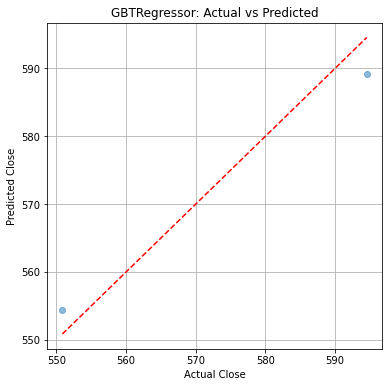

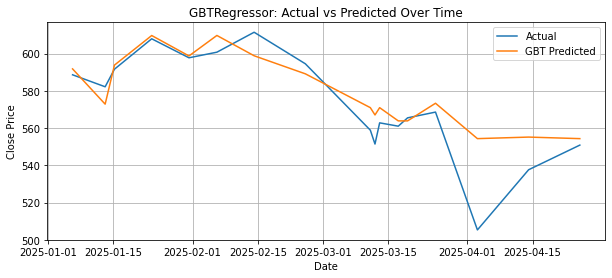

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, expr, avg, sum as spark_sum
from pyspark.sql import DataFrame

def compute_metrics(preds: DataFrame, model_name: str):
    # Add residual column
    preds = preds.withColumn("residual", col("prediction") - col("label"))
    
    # MAE and RMSE
    metrics_row = preds.select(
        expr("avg(abs(residual))").alias("MAE"),
        expr("sqrt(avg(residual * residual))").alias("RMSE")
    ).first()
    mae  = metrics_row["MAE"]
    rmse = metrics_row["RMSE"]
    
    # R2: compute mean(label) first
    mean_label = preds.select(avg("label")).first()[0]
    
    # SSE and SST
    sse = preds.select(spark_sum((col("label") - col("prediction"))**2)).first()[0]
    sst = preds.select(spark_sum((col("label") - mean_label)**2)).first()[0]
    r2  = 1 - sse / sst if sst != 0 else None
    
    print(f"\n=== {model_name} Metrics ===")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}" if r2 is not None else "R2: undefined (zero variance in labels)")
    
    return preds

preds_gbt = compute_metrics(preds_gbt, "GBTRegressor")
preds_xgb = compute_metrics(preds_xgb, "XGBRegressor")

# Sample down for plotting
sample_gbt = preds_gbt.sample(fraction=0.2, seed=42).toPandas()
sample_xgb = preds_xgb.sample(fraction=0.2, seed=42).toPandas()

# Actual vs Predicted scatter
for df, name in [(sample_gbt, "GBTRegressor")]:
    plt.figure(figsize=(6,6))
    plt.scatter(df["label"], df["prediction"], alpha=0.5)
    mn, mx = df["label"].min(), df["label"].max()
    plt.plot([mn, mx], [mn, mx], "r--")
    plt.title(f"{name}: Actual vs Predicted")
    plt.xlabel("Actual Close")
    plt.ylabel("Predicted Close")
    plt.grid()
    plt.show()

# Time-series overlay
if "timestamp" in preds_gbt.columns:
    ts_pd = preds_gbt.select("timestamp","label","prediction") \
        .orderBy("timestamp") \
        .toPandas()
    plt.figure(figsize=(10,4))
    plt.plot(ts_pd["timestamp"], ts_pd["label"], label="Actual")
    plt.plot(ts_pd["timestamp"], ts_pd["prediction"], label="GBT Predicted")
    plt.title("GBTRegressor: Actual vs Predicted Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.show()


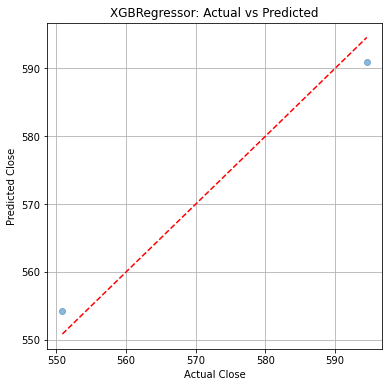

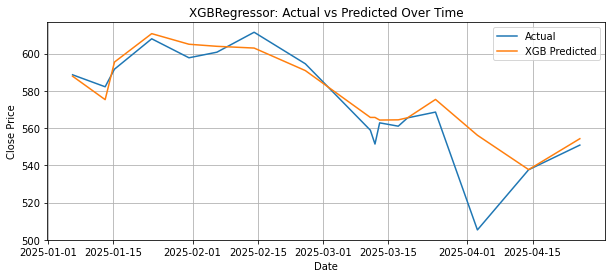

In [0]:
# Actual vs Predicted scatter
for df, name in [(sample_xgb, "XGBRegressor")]:
    plt.figure(figsize=(6,6))
    plt.scatter(df["label"], df["prediction"], alpha=0.5)
    mn, mx = df["label"].min(), df["label"].max()
    plt.plot([mn, mx], [mn, mx], "r--")
    plt.title(f"{name}: Actual vs Predicted")
    plt.xlabel("Actual Close")
    plt.ylabel("Predicted Close")
    plt.grid()
    plt.show()

# Time-series overlay
if "timestamp" in preds_xgb.columns:
    ts_pd = preds_xgb.select("timestamp","label","prediction") \
        .orderBy("timestamp") \
        .toPandas()
    plt.figure(figsize=(10,4))
    plt.plot(ts_pd["timestamp"], ts_pd["label"], label="Actual")
    plt.plot(ts_pd["timestamp"], ts_pd["prediction"], label="XGB Predicted")
    plt.title("XGBRegressor: Actual vs Predicted Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.show()

### Feature Importance

Gain

feature importance low 734.973388671875 close 51.14740753173828 open 46.91270446777344 high 19.938884735107422

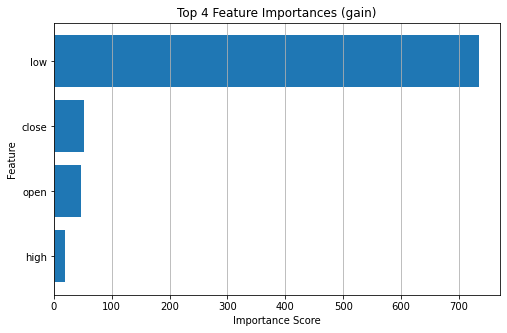

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Grab the fitted XGBoost stage from your pipeline
xgb_stage = model_xgb.stages[-1]

# 2) Retrieve the native Booster via get_booster()
booster = xgb_stage.get_booster()

# 3) Choose importance metric (e.g. “gain”, “weight”, or “cover”)
importance_type = "gain"

raw_importance = booster.get_score(importance_type=importance_type)

# 5) Map indices “f#” → your original feature names
feature_names = assembler.getInputCols()
importance_list = []
for f_key, score in raw_importance.items():
    # f_key looks like "f0", "f1", etc.
    idx = int(f_key[1:])            # strip the leading “f” to get integer index
    if idx < len(feature_names):
        importance_list.append((feature_names[idx], float(score)))

# 6) Build a Pandas DataFrame and sort descending
imp_df = pd.DataFrame(importance_list, columns=["feature", "importance"])
imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)

# 7) Display as a Spark DataFrame in Databricks
display(spark.createDataFrame(imp_df))

# 8) (Optional) Plot top 10
top_n = min(10, len(imp_df))
top_imp = imp_df.head(top_n)
plt.figure(figsize=(8, 5))
plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1])
plt.title(f"Top {top_n} Feature Importances ({importance_type})")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis="x")
plt.show()


Weight

feature importance open 678.0 low 332.0 close 251.0 high 250.0

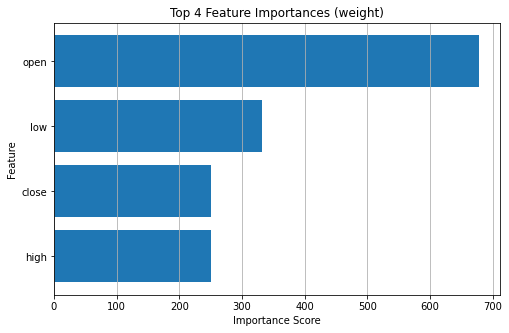

In [0]:
# 3) Choose importance metric (e.g. “gain”, “weight”, or “cover”)
importance_type = "weight"

raw_importance = booster.get_score(importance_type=importance_type)

# 5) Map indices “f#” → your original feature names
feature_names = assembler.getInputCols()
importance_list = []
for f_key, score in raw_importance.items():
    # f_key looks like "f0", "f1", etc.
    idx = int(f_key[1:])            # strip the leading “f” to get integer index
    if idx < len(feature_names):
        importance_list.append((feature_names[idx], float(score)))

# 6) Build a Pandas DataFrame and sort descending
imp_df = pd.DataFrame(importance_list, columns=["feature", "importance"])
imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)

# 7) Display as a Spark DataFrame in Databricks
display(spark.createDataFrame(imp_df))

# 8) (Optional) Plot top 10
top_n = min(10, len(imp_df))
top_imp = imp_df.head(top_n)
plt.figure(figsize=(8, 5))
plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1])
plt.title(f"Top {top_n} Feature Importances ({importance_type})")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis="x")
plt.show()


Cover

feature importance low 29.876506805419922 close 21.52988052368164 high 19.09600067138672 open 13.146018028259277

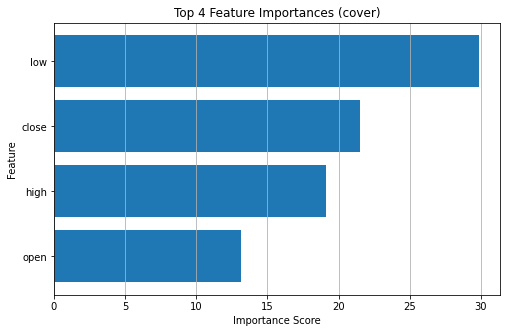

In [0]:
# 3) Choose importance metric (e.g. “gain”, “weight”, or “cover”)
importance_type = "cover"

raw_importance = booster.get_score(importance_type=importance_type)

# 5) Map indices “f#” → your original feature names
feature_names = assembler.getInputCols()
importance_list = []
for f_key, score in raw_importance.items():
    # f_key looks like "f0", "f1", etc.
    idx = int(f_key[1:])            # strip the leading “f” to get integer index
    if idx < len(feature_names):
        importance_list.append((feature_names[idx], float(score)))

# 6) Build a Pandas DataFrame and sort descending
imp_df = pd.DataFrame(importance_list, columns=["feature", "importance"])
imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)

# 7) Display as a Spark DataFrame in Databricks
display(spark.createDataFrame(imp_df))

# 8) (Optional) Plot top 10
top_n = min(10, len(imp_df))
top_imp = imp_df.head(top_n)
plt.figure(figsize=(8, 5))
plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1])
plt.title(f"Top {top_n} Feature Importances ({importance_type})")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis="x")
plt.show()


## Stock + News Data

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, expr, avg, sum as spark_sum
from pyspark.sql import DataFrame

def compute_metrics(preds: DataFrame, model_name: str):
    # Add residual column
    preds = preds.withColumn("residual", col("prediction") - col("label"))
    
    # MAE and RMSE
    metrics_row = preds.select(
        expr("avg(abs(residual))").alias("MAE"),
        expr("sqrt(avg(residual * residual))").alias("RMSE")
    ).first()
    mae  = metrics_row["MAE"]
    rmse = metrics_row["RMSE"]
    
    # R2: compute mean(label) first
    mean_label = preds.select(avg("label")).first()[0]
    
    # SSE and SST
    sse = preds.select(spark_sum((col("label") - col("prediction"))**2)).first()[0]
    sst = preds.select(spark_sum((col("label") - mean_label)**2)).first()[0]
    r2  = 1 - sse / sst if sst != 0 else None
    
    print(f"\n=== {model_name} Metrics ===")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}" if r2 is not None else "R2: undefined (zero variance in labels)")
    
    return preds


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-3886301877404304>:32
     28     print(f"R2  : {r2:.4f}" if r2 is not None else "R2: undefined (zero variance in labels)")
     30     return preds
---> 32 preds_gbt = compute_metrics(preds_gbt, "GBTRegressor")
     33 preds_xgb = compute_metrics(preds_xgb, "XGBRegressor")
     35 # Sample down for plotting

NameError: name 'preds_gbt' is not defined


=== XGBRegressor Metrics ===
MAE : 6.9987
RMSE: 9.9030
R2  : 0.8671


/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field tfidf_. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


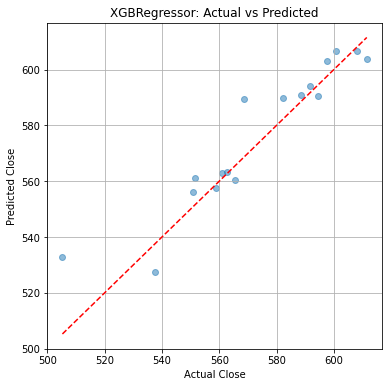

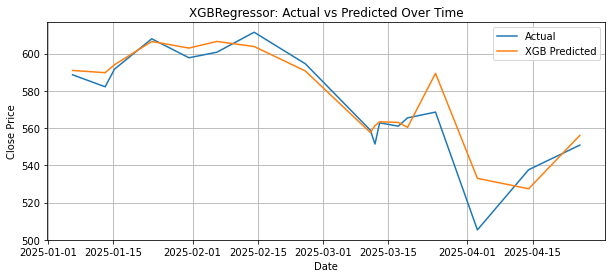

In [0]:
preds_xgb = compute_metrics(preds_xgb, "XGBRegressor")

#sample_xgb = preds_xgb.sample(fraction=0.2, seed=42).toPandas()

# Actual vs Predicted scatter
for df, name in [(preds_xgb.toPandas(), "XGBRegressor")]:
    plt.figure(figsize=(6,6))
    plt.scatter(df["label"], df["prediction"], alpha=0.5)
    mn, mx = df["label"].min(), df["label"].max()
    plt.plot([mn, mx], [mn, mx], "r--")
    plt.title(f"{name}: Actual vs Predicted")
    plt.xlabel("Actual Close")
    plt.ylabel("Predicted Close")
    plt.grid()
    plt.show()

# Time-series overlay
if "timestamp" in preds_xgb.columns:
    ts_pd = preds_xgb.select("timestamp","label","prediction") \
        .orderBy("timestamp") \
        .toPandas()
    plt.figure(figsize=(10,4))
    plt.plot(ts_pd["timestamp"], ts_pd["label"], label="Actual")
    plt.plot(ts_pd["timestamp"], ts_pd["prediction"], label="XGB Predicted")
    plt.title("XGBRegressor: Actual vs Predicted Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid()
    plt.show()

### Feature Importance

Gain

feature importance low 1956.273193359375 vwap 1251.9969482421875 open 72.38814544677734 close 59.17497634887695 count_Weather 29.03989601135254 count_Well 20.736831665039062 count_Podcasts 12.654296875 trade_count 11.517778396606445 count_U_S 4.694694519042969 count_Books 4.405026435852051 high 4.100470066070557 count_Business_Day 3.5248095989227295 count_Arts 3.038652181625366 count_Climate 2.445856809616089 count_Style 2.0504150390625 count_Health 1.8078275918960571 count_Magazine 1.6810873746871948 volume 1.4197088479995728 count_World 0.4550361633300781 count_Food 0.340715616941452 count_Theater 0.31747761368751526 count_Opinion 0.19136881828308105 count_Sports 0.09301948547363281 count_New_York 0.08169852197170258 count_Fashion_Style 0.055588722229003906 count_Corrections 0.03766798973083496 count_Real_Estate 0.0011958703398704529 count_Technology 0.0011562998406589031

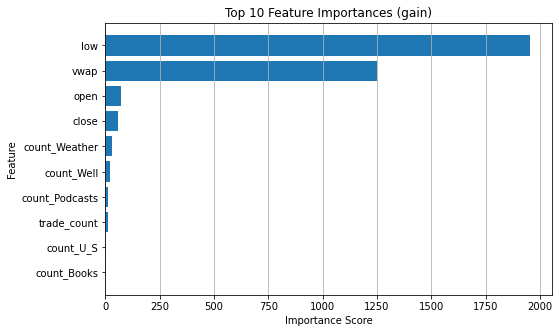

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Grab the fitted XGBoost stage from your pipeline
xgb_stage = model_xgb.stages[-1]

# 2) Retrieve the native Booster via get_booster()
booster = xgb_stage.get_booster()

# 3) Choose importance metric (e.g. “gain”, “weight”, or “cover”)
importance_type = "gain"

raw_importance = booster.get_score(importance_type=importance_type)

# 5) Map indices “f#” → your original feature names
feature_names = assembler.getInputCols()
importance_list = []
for f_key, score in raw_importance.items():
    # f_key looks like "f0", "f1", etc.
    idx = int(f_key[1:])            # strip the leading “f” to get integer index
    if idx < len(feature_names):
        importance_list.append((feature_names[idx], float(score)))

# 6) Build a Pandas DataFrame and sort descending
imp_df = pd.DataFrame(importance_list, columns=["feature", "importance"])
imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)

# 7) Display as a Spark DataFrame in Databricks
display(spark.createDataFrame(imp_df))

# 8) (Optional) Plot top 10
top_n = min(10, len(imp_df))
top_imp = imp_df.head(top_n)
plt.figure(figsize=(8, 5))
plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1])
plt.title(f"Top {top_n} Feature Importances ({importance_type})")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis="x")
plt.show()


Weight

feature importance close 200.0 low 119.0 count_Arts 39.0 high 37.0 trade_count 30.0 vwap 26.0 volume 25.0 open 14.0 count_Climate 13.0 count_Well 8.0 count_Weather 7.0 count_Theater 4.0 count_Magazine 3.0 count_Health 3.0 count_Business_Day 3.0 count_Food 2.0 count_New_York 2.0 count_U_S 2.0 count_Books 2.0 count_Fashion_Style 1.0 count_Opinion 1.0 count_Podcasts 1.0 count_Real_Estate 1.0 count_Sports 1.0 count_Style 1.0 count_Technology 1.0 count_Corrections 1.0 count_World 1.0

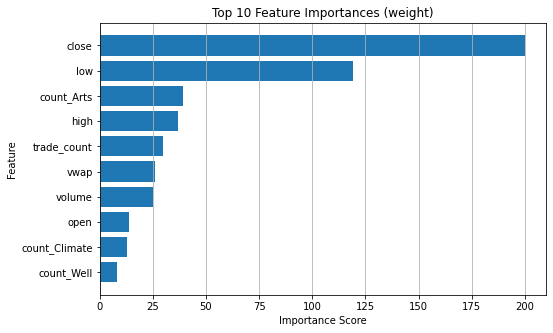

In [0]:
# 3) Choose importance metric (e.g. “gain”, “weight”, or “cover”)
importance_type = "weight"

raw_importance = booster.get_score(importance_type=importance_type)

# 5) Map indices “f#” → your original feature names
feature_names = assembler.getInputCols()
importance_list = []
for f_key, score in raw_importance.items():
    # f_key looks like "f0", "f1", etc.
    idx = int(f_key[1:])            # strip the leading “f” to get integer index
    if idx < len(feature_names):
        importance_list.append((feature_names[idx], float(score)))

# 6) Build a Pandas DataFrame and sort descending
imp_df = pd.DataFrame(importance_list, columns=["feature", "importance"])
imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)

# 7) Display as a Spark DataFrame in Databricks
display(spark.createDataFrame(imp_df))

# 8) (Optional) Plot top 10
top_n = min(10, len(imp_df))
top_imp = imp_df.head(top_n)
plt.figure(figsize=(8, 5))
plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1])
plt.title(f"Top {top_n} Feature Importances ({importance_type})")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis="x")
plt.show()


Cover

feature importance low 59.49580001831055 vwap 31.115385055541992 high 26.189189910888672 trade_count 25.366666793823242 count_Opinion 23.0 count_New_York 21.5 open 21.214284896850586 count_Podcasts 20.0 close 18.549999237060547 count_Magazine 18.0 volume 15.039999961853027 count_Weather 13.571428298950195 count_Books 13.5 count_World 13.0 count_Food 12.0 count_Sports 12.0 count_Well 12.0 count_Business_Day 11.666666984558105 count_Health 11.666666984558105 count_Technology 11.0 count_Climate 9.15384578704834 count_Style 9.0 count_Corrections 7.0 count_Theater 7.0 count_Fashion_Style 6.0 count_U_S 6.0 count_Real_Estate 5.0 count_Arts 4.487179279327393

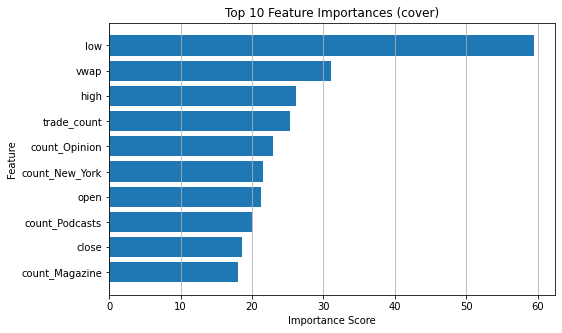

In [0]:
# 3) Choose importance metric (e.g. “gain”, “weight”, or “cover”)
importance_type = "cover"

raw_importance = booster.get_score(importance_type=importance_type)

# 5) Map indices “f#” → your original feature names
feature_names = assembler.getInputCols()
importance_list = []
for f_key, score in raw_importance.items():
    # f_key looks like "f0", "f1", etc.
    idx = int(f_key[1:])            # strip the leading “f” to get integer index
    if idx < len(feature_names):
        importance_list.append((feature_names[idx], float(score)))

# 6) Build a Pandas DataFrame and sort descending
imp_df = pd.DataFrame(importance_list, columns=["feature", "importance"])
imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)

# 7) Display as a Spark DataFrame in Databricks
display(spark.createDataFrame(imp_df))

# 8) (Optional) Plot top 10
top_n = min(10, len(imp_df))
top_imp = imp_df.head(top_n)
plt.figure(figsize=(8, 5))
plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1])
plt.title(f"Top {top_n} Feature Importances ({importance_type})")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis="x")
plt.show()
